**Лабораторная 5. Деревья решений**

Задание

Выбор датасета

Я на восьмой позиции в группе, поэтому использую датасет про грибы

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import math
from collections import Counter
import logging

#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')



eps = 1e-9

path = "/home/uvusibuneka/Desktop/СИИ/Module 2/lab5/mushroom.csv"
df = pd.read_csv(path)

target_name = 'poisonous'
df

In [ ]:
df.columns

Предварительная обработка данных

In [ ]:
target = df[target_name]
df = df.drop(target_name, axis=1)
df.dropna()

Выберем случайным образом sqrt(n) признаков

In [ ]:
count = len(df.T) - round(math.sqrt(len(df.T))) + 8
drop_features = rnd.choices(k=count, population=df.columns)
if target_name in drop_features:
    drop_features.remove(target_name)
print(len(df.T))
df = df.drop(columns=drop_features, axis=1)
print(len(df.T))

Разобьем выборку

In [5]:
df[target_name] = target
df_train = df.sample(frac=0.7)
X_train, y_train = df_train.drop(target_name, axis=1), df_train[target_name]
X_test, y_test = df.drop(df_train.index).drop(target_name, axis=1), df.drop(df_train.index)[target_name]

Статистика по датасету

In [ ]:
df.describe()

In [ ]:
for f in df.columns:
    df[f].value_counts().plot(kind="bar")
    plt.title(f)
    plt.show()

In [ ]:
print(len(df.T))

Соберем методы в отдельный класс

In [9]:
class Node:
    def __init__(self, T: pd.DataFrame):
        self.children = None
        self.value = None
        self.check = None
        self.T = T
        self.probabilities = None
        logging.info('Node initialized')

class ClassificationDecisionTree:
    def __init__(self, df: pd.DataFrame):
        self.root = Node(df)
        self.unique_values = {f: df[f].unique() for f in df.columns}
        self.thresholds = [0, 1]

    def _entropy(self, C: pd.Series) -> float:
        logging.info('Calculating entropy')
        entropy = 0
        for c in C.unique():
            p = len(C[C == c]) / len(C)
            if p > 0: 
                entropy -= p * math.log2(p)
        return entropy
    
    def _term_entropy(self, T:pd.DataFrame, check: str, C:str) -> float:
        logging.info('Calculating terminal entropy')
        sum = 0
        for t in T[check].unique():
            entropy = self._entropy(T[T[check] == t][C])
            sum += len(T[T[check] == t])/len(T) * entropy
        return sum
    
    def _split(self, T: pd.DataFrame, check: str)-> float:
        logging.info('Calculating split')
        total_count = len(T)
        entropy = 0.0
        for value in T[check].unique():
            value_count = len(T[T[check] == value])
            probability = value_count / total_count
            
            if probability > 0:  
                entropy -= probability * math.log2(probability)
        if entropy == 0:
            return eps
        return entropy
    
    def _gain(self, T: pd.DataFrame, check: str, C:str) -> float:
        logging.info('Calculating gain')
        return (self._entropy(T[C]) - self._term_entropy(T, check, C))/self._split(T, check)
    
    def predict(self, x: pd.Series):
        logging.info('Making prediction')
        t = self.root
        while (t.children is not None) and (t.check is not None) and (t.children != {}):
            t = t.children[x[t.check]]
        return t.value
    

    def _build(self, T: pd.DataFrame, node: Node = None) -> Node:
        #logging.info('Unique values is {}'.format(self.unique_values))
        #logging.info('Building tree')
        if node is None:
            node = self.root

        if len(T[target_name].unique()) == 1:
            node.value = T[target_name].unique()[0]
            node.probabilities = dict()
            node.probabilities[node.value] = 1.0
            return node
        
        check_str = T.columns[pd.Series([self._gain(T, f, target_name) for f in  np.delete(T.columns, np.where(T.columns == target_name))]).argmax()]
        node.check = check_str
        unique_checks = self.unique_values[check_str]
        node.children = dict()
        unique_checks = np.delete(unique_checks, np.where(unique_checks == target_name))
        for t in unique_checks:
            filtered_data = T[T[check_str] == t]
            cur_node = Node(filtered_data)
            if filtered_data.empty or len(filtered_data) == len(T):
                cur_node.value = T[target_name].mode()[0]
                counts = Counter(T[target_name])
                cur_node.probabilities = dict({cls: count/len(T) for cls, count in counts.items()})
                self.thresholds += {count/len(T) for _, count in counts.items()}
            else:
                cur_node = self._build(filtered_data, cur_node)

            node.children[t] = cur_node
        return node
    
    def fit(self, T: pd.DataFrame):
        logging.info('Fitting model')
        self._build(T)

    def error_matrix(self, X_test: pd.DataFrame, y_test: pd.Series, threshold: float = 0.5) -> pd.DataFrame:
        logging.info('Calculating error matrix')
        unique_classes = y_test.unique()

        m_err = pd.DataFrame(0, index=[f"Actual result is {y}" for y in unique_classes],
                             columns=[f"Predicted result is {y}" for y in unique_classes])

        for x, y in zip(X_test.iterrows(), y_test):
            actual_label = f"Actual result is {y}"
            pred = self.predict_proba(x[1])
            if "e" in pred.keys() and pred["e"] > threshold:
                result = "e"
            else:
                result = "p"
            predicted_label = f"Predicted result is {result}"
            m_err.at[actual_label, predicted_label] += 1

        return m_err
    
    def accuracy(self, X_test: pd.DataFrame, y_test: pd.Series, threshold: float = 0.5) -> float:
        logging.info('Calculating accuracy')
        m_err = self.error_matrix(X_test, y_test, threshold)
        return m_err.values.diagonal().sum() / m_err.values.sum()
    
    def precision(self, X_test: pd.DataFrame, y_test: pd.Series, threshold: float = 0.5) -> float:
        TP = 0
        FP = 0
        for x, y in zip(X_test.iterrows(), y_test):
            pred = self.predict_proba(x[1])
            if "e" in pred.keys() and pred["e"] > threshold and y == "e":
                TP += 1

            if "e" in pred.keys() and pred["e"] > threshold and y != "e":
                FP += 1
        if(TP + FP == 0):
            return 1
        return TP / (TP + FP)
    
    def recall(self, X_test: pd.DataFrame, y_test: pd.Series, threshold: float = 0.5) -> float:
        return self.TPR(X_test, y_test, threshold)
    
    def f1_score(self, X_test: pd.DataFrame, y_test: pd.Series) -> float:
        logging.info('Calculating f1 score')
        precision = self.precision(X_test, y_test)
        recall = self.recall(X_test, y_test)
        return 2 * precision * recall / (precision + recall + eps)
    
    def _I(self, a, b):
        if a < b:
            return 0
        
        if a == b:
            return 0.5
        
        if a > b:
            return 1
        
    def TPR(self, X_test: pd.DataFrame, y_test: pd.DataFrame, threshold: float = 0.5) -> float:
        logging.info('Calculating TPR')
        TP = 0
        FN = 0
        for x, y in zip(X_test.iterrows(), y_test):
            pred = self.predict_proba(x[1])
            if "e" in pred.keys() and pred["e"] > threshold and y == "e":
                TP += 1

            if "e" in pred.keys() and pred["e"] <= threshold and y == "e":
                FN += 1

        return TP / (TP + FN)
    
        
    def FPR(self, X_test: pd.DataFrame, y_test: pd.DataFrame, threshold: float = 0.5) -> float:
        logging.info('Calculating FPR')
        TN = 0
        FP = 0
        for x, y in zip(X_test.iterrows(), y_test):
            pred = self.predict_proba(x[1])
            if "e" in pred.keys() and pred["e"] <= threshold and y != "e":
                TN += 1

            if "e" in pred.keys() and pred["e"] > threshold and y != "e":
                FP += 1

        return FP / (FP + TN)

    def predict_proba(self, x: pd.Series) -> zip:
        logging.info('Making prediction probability')
        t = self.root
        while (t.children is not None) and (t.check is not None):
            t = t.children[x[t.check]]
        return t.probabilities
    
    def roc(self, X_test: pd.DataFrame, y_test: pd.DataFrame):
        self.thresholds.sort()
        points = []
        for threshold in self.thresholds:
            points.append([self.FPR(X_test, y_test, threshold), self.TPR(X_test, y_test, threshold)])
        points.sort()
        points_df = pd.DataFrame(points, columns=['FPR', 'TPR'])

        plt.figure(figsize=(8, 6))
        plt.plot(points_df['FPR'], points_df['TPR'], marker='o', label='ROC Curve')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')  # Линия случайного угадывания
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

    def precision_recall(self, X_test, y_test):
        self.thresholds.sort()
        points_df = pd.DataFrame(columns=['Recall', 'Precision'])
        for threshold in self.thresholds:
            recall = self.recall(X_test, y_test, threshold)
            precision = self.precision(X_test, y_test, threshold)
            points_df.loc[len(points_df)] = [recall, precision]
        
        plt.figure(figsize=(8, 6))
        plt.plot(points_df['Recall'], points_df['Precision'], marker='o', label='Precision-Recall Curve')
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()


In [ ]:
tree = ClassificationDecisionTree(X_train)
tree._entropy(target)

In [11]:
X_train[target_name] = y_train

In [12]:
tree.fit(X_train)

In [ ]:
tree.predict(X_test.iloc[0])


In [ ]:
tree.error_matrix(X_test, y_test)

In [ ]:
accuracy = tree.accuracy(X_test, y_test)
precision = tree.precision(X_test, y_test)
recall = tree.recall(X_test, y_test)
f1_score = tree.f1_score(X_test, y_test)
print(accuracy, precision, recall, f1_score)

In [ ]:
tree.FPR(X_test, y_test)


In [ ]:
tree.TPR(X_test, y_test)


In [ ]:
tree.roc(X_test, y_test)

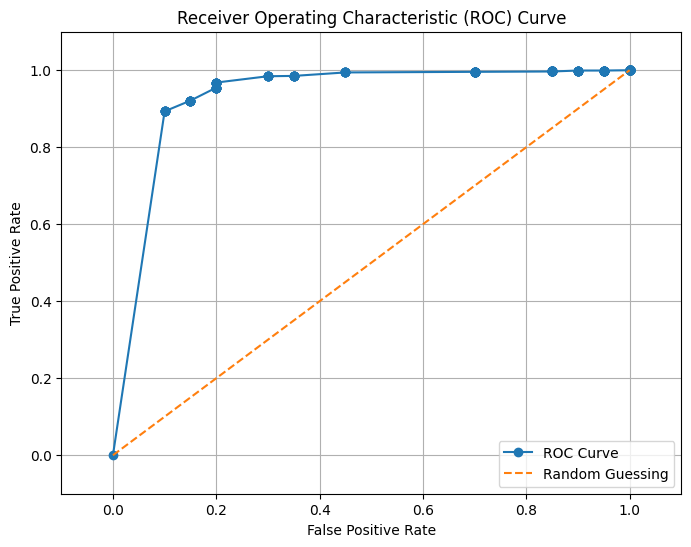

In [ ]:
tree.precision_recall(X_test, y_test)

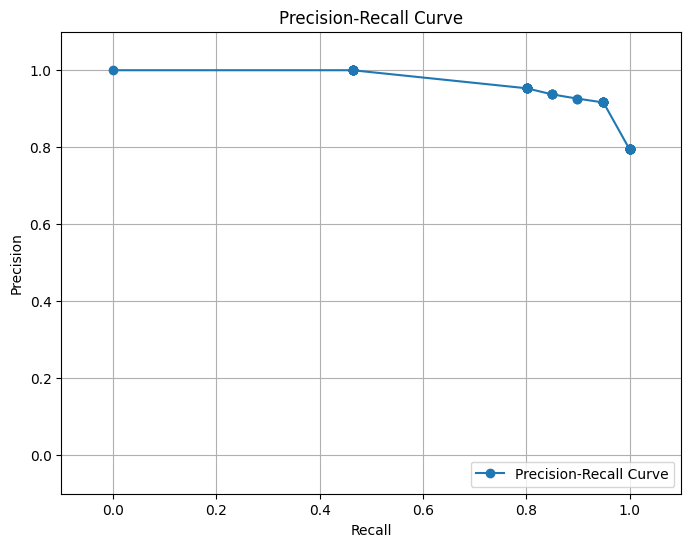](attachment:image.png)